In [688]:
import os
import pandas as pd
import numpy as np
from collections import deque
from io import StringIO
from scipy.sparse import lil_matrix, csr_matrix
from sklearn.cluster import AffinityPropagation

from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import normalized_mutual_info_score

import matplotlib.pyplot as plt

%matplotlib inline

# Affinity Propagation на матрицах, для оценки адекватности алгоритма на графах

In [490]:
class CustomAffinityPropagation(object):
    def __init__(self, similarity_measure = None):
        if similarity_measure is None:
            self.similarity_measure = lambda x, y: -np.power(x - y, 2).sum()
        else: 
            self.similarity_measure = similarity_measure
        
        self.S = None
        self.A = None
        self.R = None
    
    def load_similarity_matrix(self, S_new):
        self.S = S_new
        if hasattr(self.S, 'todense'):
            self.A = csr_matrix((S_new.shape[0], S_new.shape[0]))
            self.R = csr_matrix((S_new.shape[0], S_new.shape[0]))
        else:
            self.A = np.zeros_like(S_new)
            self.R = np.zeros_like(S_new)
        
    def calc_similarity_matrix(self, X):
        self.S = np.zeros((X.shape[0], X.shape[0]))
        self.A = np.zeros_like(self.S)
        self.R = np.zeros_like(self.S)
        for i in range(X.shape[0]):
            for j in range(X.shape[0]):
                self.S[i, j] = self.similarity_measure(X[i,:], X[j,:])
                
        self.S[np.diag_indices_from(self.S)] = np.median(self.S)#np.random.normal(loc=-5, scale=2) / 1e-8
        
        return self.S
    
    def update_responsibility(self, damping=.9):
        # For every column k, except for the column with the maximum value the max is the same.
        # So we can subtract the maximum for every row, 
        # and only need to do something different for k == argmax

        v = self.S + self.A
        rows = np.arange(self.S.shape[0])
        # We only compare the current point to all other points, 
        # so the diagonal can be filled with -infinity
        np.fill_diagonal(v, -np.inf)

        # max values
        idx_max = np.argmax(v, axis=1)
        first_max = v[rows, idx_max]

        # Second max values. For every column where k is the max value.
        v[rows, idx_max] = -np.inf
        second_max = v[rows, np.argmax(v, axis=1)]

        # Broadcast the maximum value per row over all the columns per row.
        max_matrix = np.zeros_like(self.R) + first_max[:, None]
        max_matrix[rows, idx_max] = second_max

        new_val = self.S - max_matrix

        self.R = self.R * damping + (1 - damping) * new_val

        
    def update_availability(self, damping=0.9):
        k_k_idx = np.arange(self.S.shape[0])
        # set a(i, k)
        a = np.array(self.R)
        a[a < 0] = 0
        np.fill_diagonal(a, 0)
        a = a.sum(axis=0) # columnwise sum
        a = a + self.R[k_k_idx, k_k_idx]

        # broadcasting of columns 'r(k, k) + sum(max(0, r(i', k))) to rows.
        a = np.ones(self.A.shape) * a

        # For every column k, subtract the positive value of k. 
        # This value is included in the sum and shouldn't be
        a -= np.clip(self.R, 0, np.inf)
        a[a > 0] = 0

        # set(a(k, k))
        w = np.array(self.R)
        np.fill_diagonal(w, 0)

        w[w < 0] = 0

        a[k_k_idx, k_k_idx] = w.sum(axis=0) # column wise sum
        self.A = self.A * damping + (1 - damping) * a
    
    
    def fit_transform(self, X=None, y=None):
        if X is not None:
            self.calc_similarity_matrix(X)
            
        for i in range(1000):
            self.update_responsibility(.9)
            self.update_availability(.9)
        
        clusters = np.argmax(self.A + self.R, axis=1)
        return clusters
            

In [491]:
X, y = make_blobs(n_samples=100, centers=5, n_features=2, random_state=42)

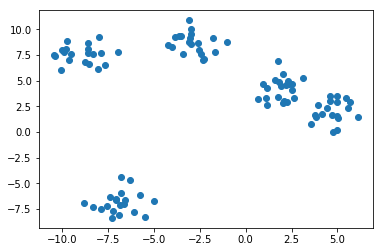

In [492]:
plt.scatter(x = X[:, 0], y = X[:, 1])

In [493]:
afine = CustomAffinityPropagation()
clusters = afine.fit_transform(X)
np.unique(clusters)#.shape

array([ 2, 11, 41, 48, 71, 78], dtype=int64)

In [494]:
unique_clust = np.unique(clusters).tolist()
mapping = dict(zip(unique_clust, range(len(unique_clust))))
mapped_clusters = np.array(list(map(lambda x: mapping[x], clusters.tolist())))

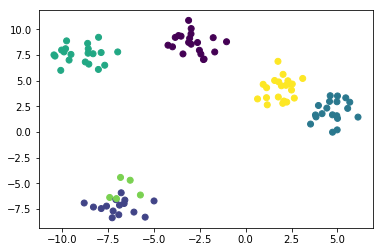

In [495]:
plt.scatter(x = X[:, 0], y = X[:, 1], c=mapped_clusters)#, cmap='tab20')

# Синтетика для теста алгоритма на графах

In [505]:
X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=42)
synth = CustomAffinityPropagation().calc_similarity_matrix(X)
np.fill_diagonal(synth, 0)

outp_data = ''
for i in range(synth.shape[0]):
    for j in range(synth.shape[1]):
        if synth[i, j] != 0:
            outp_data += f"{i}\t{j}\t{synth[i, j]}\n"
            
with open("./Gowalla/synth.txt", "w") as f:
    f.write(outp_data)

In [548]:
rawdata = None
with open('./Gowalla/exemplars.txt', 'r') as f:
    rawdata = f.read()
    
clusters = pd.read_csv(StringIO(rawdata), sep='\t', header=None)

In [549]:
unique_clust = np.unique(clusters[1]).tolist()
mapping = dict(zip(unique_clust, range(len(unique_clust))))
mapped_clusters = np.array(list(map(lambda x: mapping[x], clusters[1].tolist())))

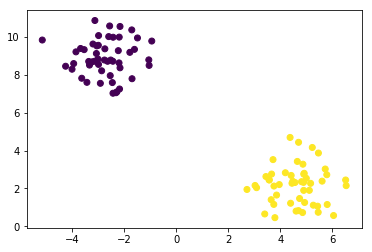

In [550]:
plt.scatter(x = X[:, 0], y = X[:, 1], c=mapped_clusters)#, cmap='tab20')

# Gowalla

# Загружаем результат кластеризации (Gowalla)

In [752]:
rawdata = None
with open('./Gowalla/exemplars.txt', 'r') as f:
    rawdata = f.read()
    
clusters = pd.read_csv(StringIO(rawdata), sep='\t', header=None)#.rename('node', 'exemplar')
clusters.columns = ['node', 'exemplar']

In [753]:
rawdata = None
with open('./Gowalla/nodes_outputs.txt', 'r') as f:
    rawdata = f.read()
    
nodes_outputs = pd.read_csv(StringIO(rawdata), sep='\t', header=None)#.rename('node', 'exemplar')
nodes_outputs.columns = ['node', 'outputs']

In [754]:
nodes_outputs['cluster'] = clusters.exemplar

In [755]:
exemplars = clusters.exemplar.tolist()

In [756]:
# транзитивное замыкание

for ix_node, record in enumerate(exemplars):
    while record != exemplars[record]:
        record = exemplars[record]
    
    if record != exemplars[ix_node]:
        print(f'transitive for {ix_node}')
        exemplars[ix_node] = record

transitive for 39232
transitive for 41455
transitive for 60073
transitive for 86164
transitive for 96333
transitive for 120112
transitive for 133110
transitive for 133112
transitive for 141526
transitive for 161801
transitive for 190264
transitive for 190265
transitive for 193834
transitive for 194562


In [757]:
# транзитивное замыкание не понадобилось

In [758]:
clusters_sizes = clusters.exemplar.value_counts()

In [772]:
print('количество малых кластеров', np.sum(clusters_sizes <= 2), f'покрытие: ', clusters_sizes[clusters_sizes <= 2].sum() / clusters_sizes.sum())

количество малых кластеров 53676 покрытие:  0.3269579990945669


In [771]:
print('количество крупных кластеров', np.sum(clusters_sizes > 2), f'покрытие: ', clusters_sizes[clusters_sizes > 2].sum() / clusters_sizes.sum())

количество крупных кластеров 15537 покрытие:  0.6730420009054331


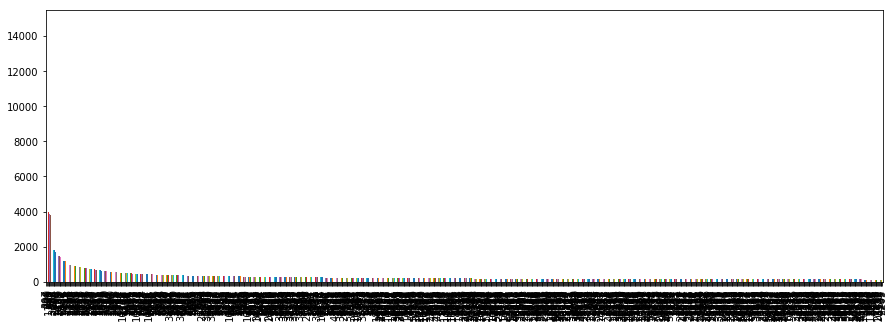

In [773]:
nodes_outputs[nodes_outputs.cluster.isin(clusters_sizes[clusters_sizes > 2].index)].outputs.sort_values(ascending=False).iloc[:1000].plot(kind='bar', figsize=(15, 5))

In [763]:
print('первые 500 кластеров по объему')
print(clusters.exemplar.value_counts())

первые 500 кластеров по объему
220       10186
440        3585
459        3148
207         978
1431        882
3           751
2196        724
1430        647
1791        557
2215        539
2089        471
1857        442
4370        441
38454       338
7480        275
1653        248
8037        232
1927        215
5568        214
1605        208
47875       201
3673        180
1           170
5849        153
68929       153
8035        146
1994        145
1903        138
41281       133
6809        132
          ...  
100436        1
143742        1
139644        1
137595        1
125016        1
153971        1
178543        1
176494        1
80287         1
53666         1
59813         1
33192         1
155689        1
158197        1
152050        1
178671        1
172524        1
153646        1
192998        1
188900        1
165940        1
188473        1
67652         1
65605         1
90185         1
45486         1
84044         1
39339         1
35241         1
118906   

# Анализируем чекины

In [588]:
rawdata = None
with open('./Gowalla/Gowalla_totalCheckins.txt', 'r') as f:
    rawdata = f.read()
    
checkins = pd.read_csv(StringIO(rawdata), sep='\t', header=None)
checkins.columns = ['user_from', 'time', 'latitude', 'longitude', 'user_to']
checkins.drop(['time', 'latitude', 'longitude'], inplace=True, axis=1)

In [589]:
def get_top_checkins(x):
    top_5 = x.user_to.value_counts().iloc[:10].index.values
    return pd.Series(top_5)

top_checkins = checkins.groupby('user_from').apply(get_top_checkins).unstack()

In [604]:
# в логах чекинов нет некоторых пользователей

In [667]:
top_checkins_corrected = top_checkins

In [668]:
top_checkins.shape[0], len(exemplars)

(107092, 196591)

In [774]:
top_checkins['cluster'] = clusters.exemplar

In [775]:
def get_relevant_checkin_share(x, share = .1):
    scores = []
    for i in range(10):
        def get_indices(n_samples):
            full_range = list(range(n_samples))

            random_boys = np.random.choice(full_range, size=int(n_samples * share), replace=False)
            difference = np.setdiff1d(full_range, random_boys)

            return random_boys, difference
        
        # скрываем некоторых пользователей
        random_boys, difference = get_indices(x.shape[0])
    
        test_users = x.iloc[random_boys]
        val_users = x.iloc[difference]
        
        # удаляем nan из выборки
        val_users_values = val_users.values.flatten()
        val_users_values = val_users_values[~np.isnan(val_users_values)]
        val_users_values = val_users_values.astype(int)
        test_users_values = test_users.values.flatten()
        test_users_values = test_users_values[~np.isnan(test_users_values)]
        test_users_values = test_users_values.astype(int)
        
        # считаем уникальные значения локация / количество пользователей на локацию 
        unique_users_val, counts_val = np.unique(val_users_values, return_counts=True)
        unique_users_val = unique_users_val[:10]
        unique_users_test, counts_test = np.unique(test_users_values, return_counts=True)
        
        # маска: попала ли локация из тестового множества в валидационное
        mask = np.array([j in unique_users_test for j in unique_users_val])#np.zeros_like(unique_users_val)
        
        scores.append(mask.sum() / mask.shape[0])
    
    return np.mean(scores)

ranking = top_checkins_corrected.groupby('cluster').apply(get_relevant_checkin_share)

In [776]:
print('кластеров с нулевым скором: ', (ranking == 0).sum())

кластеров с нулевым скором:  40724


In [777]:
print('кластеров с ненулевым скором: ', (ranking != 0).sum())

кластеров с ненулевым скором:  911


In [778]:
print('средний скор по кластерам: ', ranking.mean())

средний скор по кластерам:  0.0020994355710339855


In [779]:
print(ranking.sort_values(ascending=False))

cluster
101862    0.52
1431      0.35
220       0.29
5692      0.28
38198     0.27
55419     0.26
64493     0.26
142       0.26
4370      0.26
2274      0.26
598       0.25
4358      0.24
45806     0.24
106174    0.24
167822    0.23
54690     0.21
99701     0.21
142261    0.21
95919     0.21
68031     0.21
40930     0.21
47852     0.21
11930     0.20
440       0.20
459       0.20
41281     0.20
106423    0.20
187731    0.20
10832     0.20
41951     0.20
          ... 
131551    0.00
131601    0.00
131546    0.00
131544    0.00
131540    0.00
131539    0.00
131534    0.00
131528    0.00
131527    0.00
131584    0.00
131604    0.00
131729    0.00
131675    0.00
131713    0.00
131708    0.00
131701    0.00
131700    0.00
131689    0.00
131684    0.00
131676    0.00
131673    0.00
131608    0.00
131660    0.00
131646    0.00
131643    0.00
131630    0.00
131629    0.00
131621    0.00
131611    0.00
109665    0.00
Length: 41635, dtype: float64
